In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method), PGD (Projected Gradient Descent) and UAP (Universal adversarial perturbations). To enhance your understanding, you will implement the PGD and UAP attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model. 

Good luck!

In [13]:
Name = 'Fateme Raeijian'
Student_ID = '402203389'

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- UAP Attack from scratch
- Visualization
- Adversarial Training


Name: 

Student Number:

In [4]:
! pip install torch torchvision numpy tqdm

  Using cached torch-2.5.1-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached torchvision-0.20.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached numpy-2.1.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached tqdm-4.66.6-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached setuptools-75.3.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached pillow-11.0.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Train Resnet on CIFAR10 (15 pts)

In [14]:
# Define batch size and transformations
batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Define a custom ResNet model
class ResNet(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
        self.fc = nn.Linear(512, num_cls)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)
        return logits

# Initialize the model and move to device
model = ResNet(num_cls=10).to(device)

In [16]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [11]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################
# Training the model
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Log training loss
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}")
################################ End #########################################

Epoch [1/100], Loss: 1.5492
Epoch [2/100], Loss: 1.1506
Epoch [3/100], Loss: 0.9444
Epoch [4/100], Loss: 0.7912
Epoch [5/100], Loss: 0.6787
Epoch [6/100], Loss: 0.5680
Epoch [7/100], Loss: 0.4709
Epoch [8/100], Loss: 0.3847
Epoch [9/100], Loss: 0.3194
Epoch [10/100], Loss: 0.2589
Epoch [11/100], Loss: 0.2159
Epoch [12/100], Loss: 0.1702
Epoch [13/100], Loss: 0.1463
Epoch [14/100], Loss: 0.1304
Epoch [15/100], Loss: 0.1064
Epoch [16/100], Loss: 0.0973
Epoch [17/100], Loss: 0.0816
Epoch [18/100], Loss: 0.0675
Epoch [19/100], Loss: 0.0533
Epoch [20/100], Loss: 0.0582
Epoch [21/100], Loss: 0.0504
Epoch [22/100], Loss: 0.0476
Epoch [23/100], Loss: 0.0461
Epoch [24/100], Loss: 0.0345
Epoch [25/100], Loss: 0.0378
Epoch [26/100], Loss: 0.0319
Epoch [27/100], Loss: 0.0256
Epoch [28/100], Loss: 0.0226
Epoch [29/100], Loss: 0.0158
Epoch [30/100], Loss: 0.0223
Epoch [31/100], Loss: 0.0285
Epoch [32/100], Loss: 0.0255
Epoch [33/100], Loss: 0.0258
Epoch [34/100], Loss: 0.0252
Epoch [35/100], Loss: 0

In [12]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################
# Evaluate model on test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')################################ End #########################################

Test Accuracy of the model on the 10000 test images: 75.54%


In [13]:
# Save model checkpoint
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)
print(f"Model saved to {model_PATH}")

Model saved to resnet18_cifar10_model_pretrained.pth


## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [14]:
! pip install torchattacks

  Using cached scipy-1.14.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
Using cached scipy-1.14.1-cp312-cp312-macosx_14_0_arm64.whl (23.1 MB)
Using cached certifi-2024.8.30-py3-none-any.whl (167 kB)


In [15]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
# FGSM Attack for different epsilon values using torchattacks library
import torchattacks

epsilon_values = [1/255, 4/255, 8/255]
for epsilon in epsilon_values:
    fgsm_attack = torchattacks.FGSM(model, eps=epsilon)
    
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        adv_images = fgsm_attack(images, labels)
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"FGSM Attack with epsilon {epsilon}: Test Accuracy = {100 * correct / total:.2f}%")
################################ End #########################################

FGSM Attack with epsilon 0.00392156862745098: Test Accuracy = 54.66%
FGSM Attack with epsilon 0.01568627450980392: Test Accuracy = 25.28%
FGSM Attack with epsilon 0.03137254901960784: Test Accuracy = 12.10%


## PGD Attack from scratch (15 pts)

In this section you should implement PGD attack from scratch.

In [17]:
# PGD Attack from scratch
class LinfPGDAttack(object):
    def __init__(self, model, epsilon=8/255, k=2, alpha=2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):
        perturbed_image = image.clone().detach().to(device)
        perturbed_image.requires_grad = True

        for _ in range(self.steps):
            outputs = self.model(perturbed_image)
            loss = criterion(outputs, label)
            loss.backward()
            
            # Update perturbed image with alpha step in the direction of the gradient
            perturbed_image = perturbed_image + self.alpha * perturbed_image.grad.sign()
            perturbed_image = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon).detach_()
            perturbed_image.requires_grad = True

        return perturbed_image

In [18]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2, 4, 8]
epsilon = 8/255  # Perturbation size
alpha = 2/255    # Step size

# Ensure the model is in evaluation mode
model.eval()

for k in k_list:
    pgd_attack = LinfPGDAttack(model, epsilon=epsilon, k=k, alpha=alpha)
    correct = 0
    total = 0
    print(f"Evaluating PGD attack with k={k}")
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # Apply PGD attack
        adv_images = pgd_attack(images, labels)
        # Predict with adversarial images
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'PGD Attack with k={k}: Test Accuracy = {accuracy:.2f}%')

Evaluating PGD attack with k=2
PGD Attack with k=2: Test Accuracy = 17.92%
Evaluating PGD attack with k=4
PGD Attack with k=4: Test Accuracy = 3.10%
Evaluating PGD attack with k=8
PGD Attack with k=8: Test Accuracy = 0.82%


## UAP Attack from scratch (15 pts)

In this section you should implement UAP attack from scratch.

In [18]:
class UAPAttack(object):
    def __init__(self, model, epsilon=8/255, delta=2/255, max_iters=10, data_loader=None):
        """
        Initializes the UAPAttack.

        Parameters:
            model (nn.Module): The target model to attack.
            epsilon (float): The maximum perturbation.
            delta (float): The step size for each iteration.
            max_iters (int): Number of iterations to perform.
            data_loader (DataLoader): DataLoader for training data to generate UAP.
        """
        self.model = model
        self.epsilon = epsilon
        self.delta = delta
        self.max_iters = max_iters
        self.data_loader = data_loader

        # Initialize universal perturbation with requires_grad=True
        self.uap = torch.zeros((1, 3, 32, 32)).to(device)
        self.uap.requires_grad = True

        # Optimizer to update the universal perturbation
        self.optimizer = optim.Adam([self.uap], lr=self.delta)

    def generate_uap(self):
        """
        Generates the Universal Adversarial Perturbation (UAP).
        
        Returns:
            torch.Tensor: The generated UAP.
        """
        self.model.eval()  # Set model to evaluation mode

        for itr in range(self.max_iters):
            print(f"UAP Generation Iteration {itr+1}/{self.max_iters}")
            for images, labels in tqdm(self.data_loader, desc=f"Iteration {itr+1}"):
                images, labels = images.to(device), labels.to(device)

                # Zero the gradients
                self.optimizer.zero_grad()

                # Apply current perturbation and clamp to [0,1]
                perturbed_images = torch.clamp(images + self.uap, 0, 1)

                # Forward pass
                outputs = self.model(perturbed_images)
                loss = nn.CrossEntropyLoss()(outputs, labels)

                # Backward pass to compute gradients w.r.t uap
                loss.backward()

                # Update the perturbation
                self.optimizer.step()

                # Project the perturbation to the epsilon ball
                with torch.no_grad():
                    self.uap = torch.clamp(self.uap, -self.epsilon, self.epsilon)
                    self.uap.requires_grad = True  # Re-enable gradient computation

        return self.uap.detach()

    def __call__(self, images):
        """
        Applies the universal adversarial perturbation to the given images.

        Parameters:
            images (torch.Tensor): Batch of images to perturb.

        Returns:
            torch.Tensor: Perturbed images.
        """
        return torch.clamp(images + self.uap, 0, 1)

In [20]:
##############################################################################
# Evaluate UAP attack on the trained model with max_iters = 10               #
##############################################################################

max_iters = 10
epsilon = 8/255
delta = 0.01  # Step size for perturbation update

# Initialize the UAP attack
uap_attack = UAPAttack(model, epsilon=epsilon, delta=delta, max_iters=max_iters, data_loader=trainloader)
print("Generating Universal Adversarial Perturbation (UAP)...")
uap = uap_attack.generate_uap()

# Evaluate the model on the test set with UAP applied
correct = 0
total = 0
print("Evaluating UAP attack on the test set...")
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    # Apply UAP to the images
    adv_images = uap_attack(images)
    # Predict with adversarial images
    outputs = model(adv_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'UAP Attack with max_iters={max_iters}: Test Accuracy = {accuracy:.2f}%')

Generating Universal Adversarial Perturbation (UAP)...
Evaluating UAP attack on the test set...
UAP Attack with max_iters=10: Test Accuracy = 75.54%


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [23]:
! pip install matplotlib

  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp312-cp312-macosx_11_0_arm64.whl (251 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.54.1-cp312-cp312-macosx_11_0_arm64.whl (2.3 MB)
Using cached kiwisolver-1.4.7-cp312-cp312-macosx_11_0_arm64.whl (63 kB)
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)


In [24]:
##############################################################################
# Implement the function described                                           #
##############################################################################

import matplotlib.pyplot as plt
import numpy as np

def visualize_attack(original_images, perturbed_images, original_labels, perturbed_labels):
    """
    Plots the original and perturbed images along with their predicted labels.
    
    Parameters:
        original_images (Tensor): Batch of original images.
        perturbed_images (Tensor): Batch of perturbed images.
        original_labels (Tensor): Predicted labels for original images.
        perturbed_labels (Tensor): Predicted labels for perturbed images.
    """
    batch_size = original_images.size(0)
    for i in range(batch_size):
        orig_img = original_images[i].cpu().detach().numpy().transpose(1, 2, 0)
        pert_img = perturbed_images[i].cpu().detach().numpy().transpose(1, 2, 0)
        orig_label = classes[original_labels[i]]
        pert_label = classes[perturbed_labels[i]]
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(orig_img)
        axes[0].set_title(f"Original: {orig_label}")
        axes[0].axis('off')
        
        axes[1].imshow(pert_img)
        axes[1].set_title(f"Perturbed: {pert_label}")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

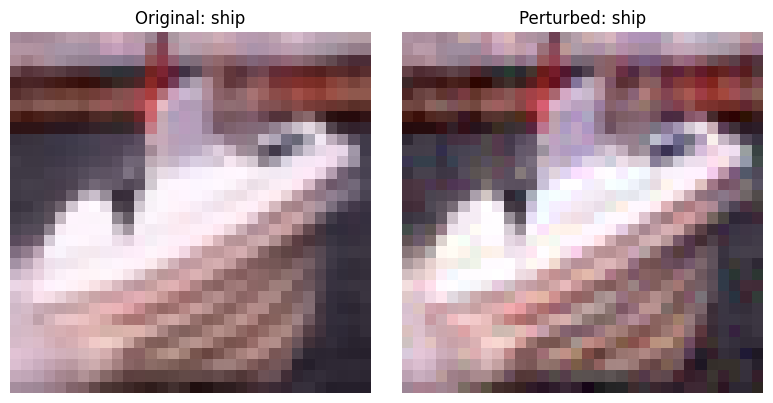

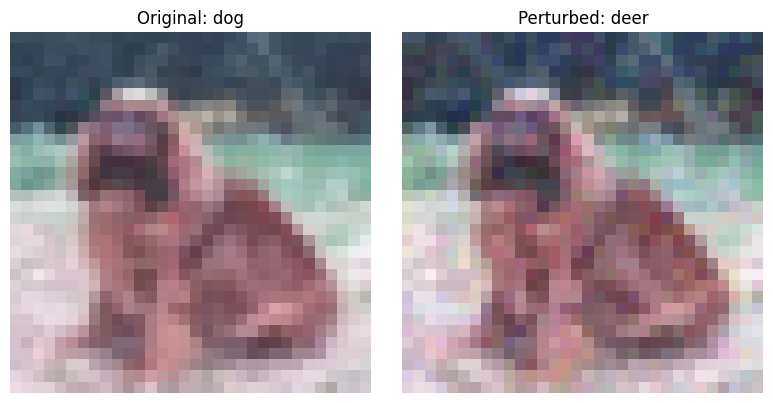

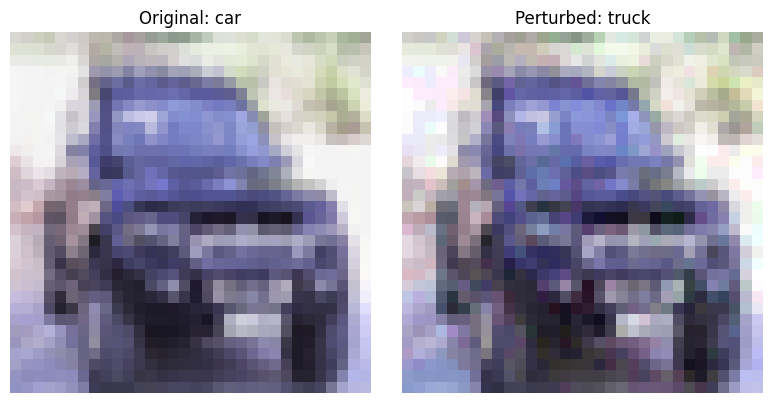

In [26]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################

import random

# Get a batch of test images
dataiter = iter(testloader)
images, labels = dataiter._next_data()
images, labels = images.to(device), labels.to(device)

# Select 3 random indices
indices = random.sample(range(images.size(0)), 3)
selected_images = images[indices]
selected_labels = labels[indices]

# Run FGSM attack
epsilon = 8/255
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)
adv_images = fgsm_attack(selected_images, selected_labels)

# Get predictions
model.eval()
with torch.no_grad():
    outputs_orig = model(selected_images)
    outputs_adv = model(adv_images)
    _, preds_orig = torch.max(outputs_orig, 1)
    _, preds_adv = torch.max(outputs_adv, 1)

# Visualize the results
visualize_attack(selected_images, adv_images, preds_orig, preds_adv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0039215703..1.0313725].


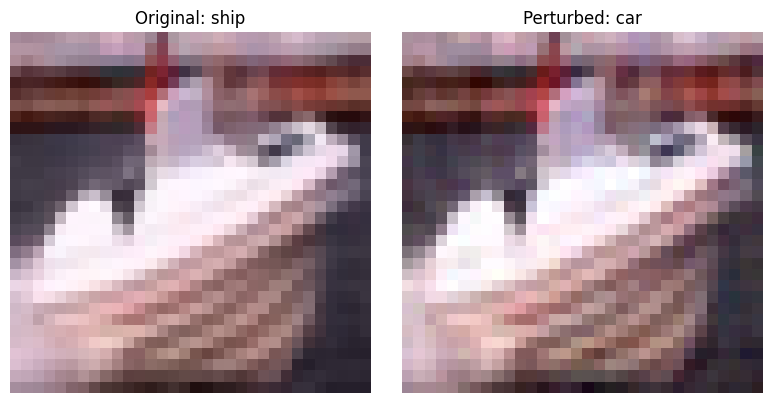

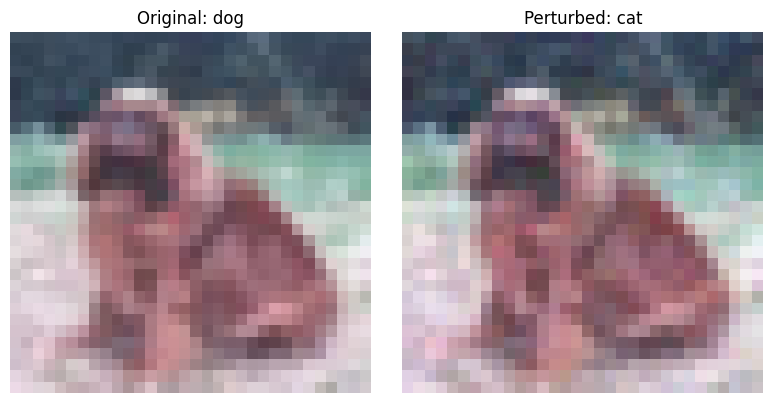

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04705883..1.0117648].


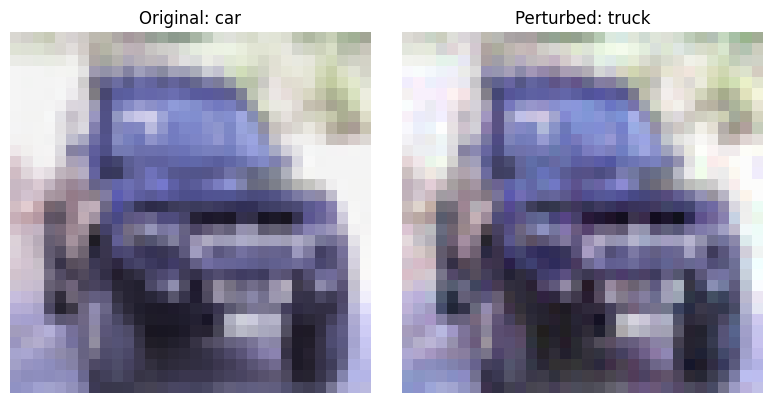

In [27]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize       #
##############################################################################

# Reusing the same selected_images and selected_labels from above

# Run PGD attack
k = 4
pgd_attack = LinfPGDAttack(model, epsilon=8/255, k=k, alpha=2/255)
adv_images = pgd_attack(selected_images, selected_labels)

# Get predictions
model.eval()
with torch.no_grad():
    outputs_orig = model(selected_images)
    outputs_adv = model(adv_images)
    _, preds_orig = torch.max(outputs_orig, 1)
    _, preds_adv = torch.max(outputs_adv, 1)

# Visualize the results
visualize_attack(selected_images, adv_images, preds_orig, preds_adv)

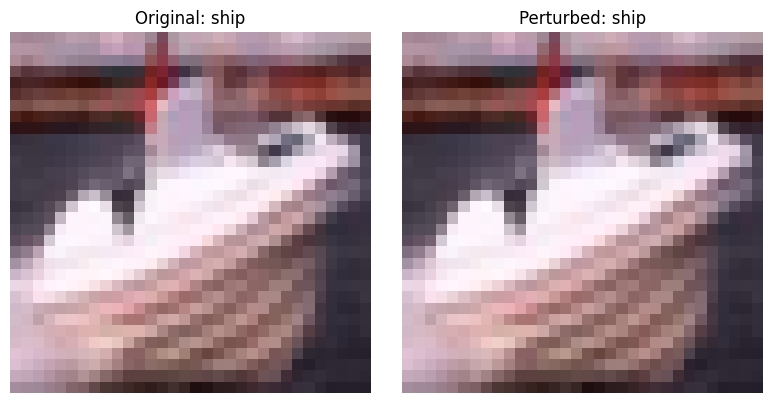

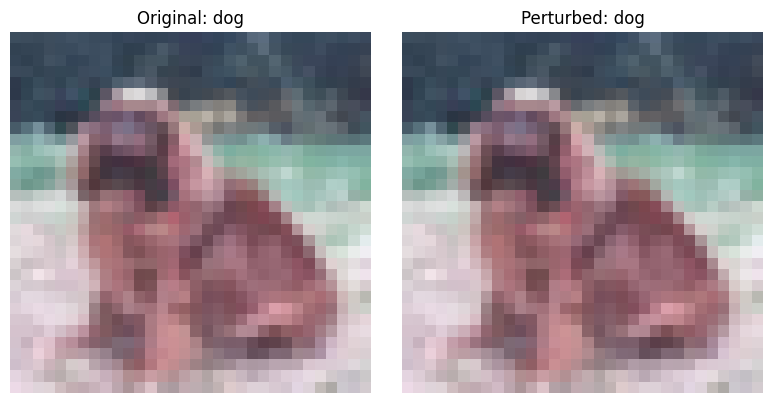

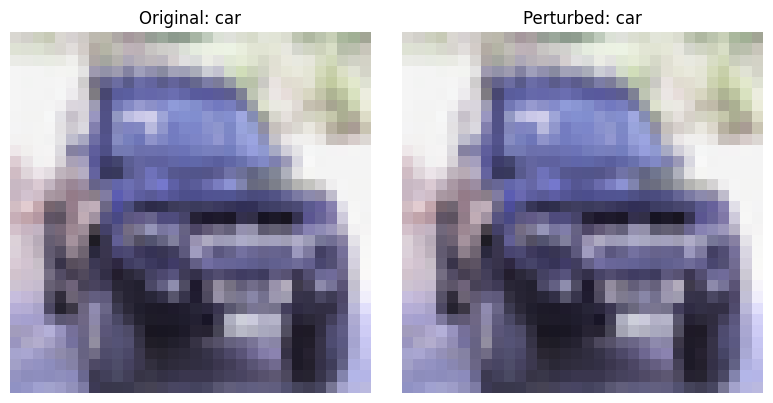

In [28]:
##############################################################################
# Choose 3 random images from testset and run UAP attack and visualize       #
##############################################################################

# Ensure that the UAP has been generated
if not hasattr(uap_attack, 'uap'):
    print("Generating UAP first...")
    uap_attack.generate_uap()

# Apply UAP attack
adv_images = uap_attack(selected_images)

# Get predictions
model.eval()
with torch.no_grad():
    outputs_orig = model(selected_images)
    outputs_adv = model(adv_images)
    _, preds_orig = torch.max(outputs_orig, 1)
    _, preds_adv = torch.max(outputs_adv, 1)

# Visualize the results
visualize_attack(selected_images, adv_images, preds_orig, preds_adv)

## Adversarial Training (35 pts)

In [19]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

# Define a custom ResNet model (same architecture as before)
class ResNetAdv(nn.Module):
    def __init__(self, num_cls):
        super().__init__()
        self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
        self.fc = nn.Linear(512, num_cls)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)
        return logits

# Initialize the adversarial model and move to device
adv_model = ResNetAdv(num_cls=10).to(device)

# Training setup
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [20]:
##############################################################################
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

import torchattacks

# Define FGSM attack with epsilon=8/255
fgsm_train = torchattacks.FGSM(adv_model, eps=8/255)

# Training loop with adversarial examples
for epoch in range(epochs):
    adv_model.train()
    running_loss = 0.0
    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial examples
        adv_images = fgsm_train(images, labels)

        # Forward pass on adversarial images
        outputs = adv_model(adv_images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    # Optional: Evaluate on test set every 10 epochs to monitor progress
    if (epoch + 1) % 10 == 0:
        adv_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for test_images, test_labels in testloader:
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                outputs = adv_model(test_images)
                _, predicted = torch.max(outputs.data, 1)
                total += test_labels.size(0)
                correct += (predicted == test_labels).sum().item()
        test_accuracy = 100 * correct / total
        print(f"Test Accuracy after Epoch {epoch+1}: {test_accuracy:.2f}%")

Epoch 1/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [1/100], Loss: 2.1218


Epoch 2/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [2/100], Loss: 1.9862


Epoch 3/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [3/100], Loss: 1.9288


Epoch 4/100: 100%|██████████| 391/391 [09:02<00:00,  1.39s/it]


Epoch [4/100], Loss: 1.8828


Epoch 5/100: 100%|██████████| 391/391 [09:01<00:00,  1.39s/it]


Epoch [5/100], Loss: 1.8398


Epoch 6/100: 100%|██████████| 391/391 [09:03<00:00,  1.39s/it]


Epoch [6/100], Loss: 1.8090


Epoch 7/100: 100%|██████████| 391/391 [09:04<00:00,  1.39s/it]


Epoch [7/100], Loss: 1.7760


Epoch 8/100: 100%|██████████| 391/391 [09:02<00:00,  1.39s/it]


Epoch [8/100], Loss: 1.7415


Epoch 9/100: 100%|██████████| 391/391 [09:02<00:00,  1.39s/it]


Epoch [9/100], Loss: 1.7087


Epoch 10/100: 100%|██████████| 391/391 [09:03<00:00,  1.39s/it]


Epoch [10/100], Loss: 1.6771
Test Accuracy after Epoch 10: 53.26%


Epoch 11/100: 100%|██████████| 391/391 [09:03<00:00,  1.39s/it]


Epoch [11/100], Loss: 1.6424


Epoch 12/100: 100%|██████████| 391/391 [08:28<00:00,  1.30s/it]


Epoch [12/100], Loss: 1.6113


Epoch 13/100: 100%|██████████| 391/391 [07:08<00:00,  1.10s/it]


Epoch [13/100], Loss: 1.5760


Epoch 14/100: 100%|██████████| 391/391 [07:08<00:00,  1.10s/it]


Epoch [14/100], Loss: 1.5339


Epoch 15/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [15/100], Loss: 1.4960


Epoch 16/100: 100%|██████████| 391/391 [07:36<00:00,  1.17s/it]


Epoch [16/100], Loss: 1.4585


Epoch 17/100: 100%|██████████| 391/391 [1:09:53<00:00, 10.72s/it] 


Epoch [17/100], Loss: 1.4199


Epoch 18/100: 100%|██████████| 391/391 [09:04<00:00,  1.39s/it]


Epoch [18/100], Loss: 1.3781


Epoch 19/100: 100%|██████████| 391/391 [09:04<00:00,  1.39s/it]


Epoch [19/100], Loss: 1.3402


Epoch 20/100: 100%|██████████| 391/391 [09:05<00:00,  1.39s/it]


Epoch [20/100], Loss: 1.2934
Test Accuracy after Epoch 20: 57.08%


Epoch 21/100: 100%|██████████| 391/391 [09:04<00:00,  1.39s/it]


Epoch [21/100], Loss: 1.2570


Epoch 22/100: 100%|██████████| 391/391 [09:02<00:00,  1.39s/it]


Epoch [22/100], Loss: 1.2185


Epoch 23/100: 100%|██████████| 391/391 [09:01<00:00,  1.38s/it]


Epoch [23/100], Loss: 1.1833


Epoch 24/100: 100%|██████████| 391/391 [09:05<00:00,  1.39s/it]


Epoch [24/100], Loss: 1.1484


Epoch 25/100: 100%|██████████| 391/391 [08:59<00:00,  1.38s/it]


Epoch [25/100], Loss: 1.1022


Epoch 26/100: 100%|██████████| 391/391 [09:02<00:00,  1.39s/it]


Epoch [26/100], Loss: 1.0723


Epoch 27/100: 100%|██████████| 391/391 [09:03<00:00,  1.39s/it]


Epoch [27/100], Loss: 1.0395


Epoch 28/100: 100%|██████████| 391/391 [09:05<00:00,  1.40s/it]


Epoch [28/100], Loss: 0.9992


Epoch 29/100: 100%|██████████| 391/391 [09:06<00:00,  1.40s/it]


Epoch [29/100], Loss: 0.9690


Epoch 30/100: 100%|██████████| 391/391 [09:06<00:00,  1.40s/it]


Epoch [30/100], Loss: 0.9382
Test Accuracy after Epoch 30: 59.32%


Epoch 31/100: 100%|██████████| 391/391 [09:06<00:00,  1.40s/it]


Epoch [31/100], Loss: 0.9080


Epoch 32/100: 100%|██████████| 391/391 [09:06<00:00,  1.40s/it]


Epoch [32/100], Loss: 0.8796


Epoch 33/100: 100%|██████████| 391/391 [09:05<00:00,  1.39s/it]


Epoch [33/100], Loss: 0.8556


Epoch 34/100: 100%|██████████| 391/391 [07:11<00:00,  1.10s/it]


Epoch [34/100], Loss: 0.8315


Epoch 35/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [35/100], Loss: 0.8005


Epoch 36/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [36/100], Loss: 0.7768


Epoch 37/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [37/100], Loss: 0.7502


Epoch 38/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [38/100], Loss: 0.7368


Epoch 39/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [39/100], Loss: 0.7061


Epoch 40/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [40/100], Loss: 0.6802
Test Accuracy after Epoch 40: 59.15%


Epoch 41/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [41/100], Loss: 0.6598


Epoch 42/100: 100%|██████████| 391/391 [07:44<00:00,  1.19s/it]


Epoch [42/100], Loss: 0.6548


Epoch 43/100: 100%|██████████| 391/391 [07:27<00:00,  1.15s/it]


Epoch [43/100], Loss: 0.6215


Epoch 44/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [44/100], Loss: 0.6027


Epoch 45/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [45/100], Loss: 0.5742


Epoch 46/100: 100%|██████████| 391/391 [1:16:12<00:00, 11.69s/it]   


Epoch [46/100], Loss: 0.5777


Epoch 47/100: 100%|██████████| 391/391 [07:11<00:00,  1.10s/it]


Epoch [47/100], Loss: 0.5473


Epoch 48/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [48/100], Loss: 0.5393


Epoch 49/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [49/100], Loss: 0.5187


Epoch 50/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [50/100], Loss: 0.5036
Test Accuracy after Epoch 50: 60.19%


Epoch 51/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [51/100], Loss: 0.4927


Epoch 52/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [52/100], Loss: 0.4811


Epoch 53/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [53/100], Loss: 0.4658


Epoch 54/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [54/100], Loss: 0.4494


Epoch 55/100: 100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch [55/100], Loss: 0.4449


Epoch 56/100: 100%|██████████| 391/391 [07:11<00:00,  1.10s/it]


Epoch [56/100], Loss: 0.4314


Epoch 57/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [57/100], Loss: 0.4088


Epoch 58/100: 100%|██████████| 391/391 [07:09<00:00,  1.10s/it]


Epoch [58/100], Loss: 0.4080


Epoch 59/100: 100%|██████████| 391/391 [07:17<00:00,  1.12s/it]


Epoch [59/100], Loss: 0.4063


Epoch 60/100: 100%|██████████| 391/391 [07:12<00:00,  1.11s/it]


Epoch [60/100], Loss: 0.3885
Test Accuracy after Epoch 60: 60.13%


Epoch 61/100: 100%|██████████| 391/391 [07:17<00:00,  1.12s/it]


Epoch [61/100], Loss: 0.3567


Epoch 62/100: 100%|██████████| 391/391 [08:11<00:00,  1.26s/it]


Epoch [62/100], Loss: 0.3520


Epoch 63/100: 100%|██████████| 391/391 [08:09<00:00,  1.25s/it]


Epoch [63/100], Loss: 0.3600


Epoch 64/100: 100%|██████████| 391/391 [07:29<00:00,  1.15s/it]


Epoch [64/100], Loss: 0.3511


Epoch 65/100: 100%|██████████| 391/391 [08:47<00:00,  1.35s/it]


Epoch [65/100], Loss: 0.3392


Epoch 66/100: 100%|██████████| 391/391 [08:14<00:00,  1.26s/it]


Epoch [66/100], Loss: 0.3368


Epoch 67/100: 100%|██████████| 391/391 [07:41<00:00,  1.18s/it]


Epoch [67/100], Loss: 0.3307


Epoch 68/100: 100%|██████████| 391/391 [08:11<00:00,  1.26s/it]


Epoch [68/100], Loss: 0.3100


Epoch 69/100: 100%|██████████| 391/391 [08:41<00:00,  1.33s/it]


Epoch [69/100], Loss: 0.3111


Epoch 70/100: 100%|██████████| 391/391 [08:15<00:00,  1.27s/it]


Epoch [70/100], Loss: 0.2957
Test Accuracy after Epoch 70: 60.38%


Epoch 71/100: 100%|██████████| 391/391 [08:42<00:00,  1.34s/it]


Epoch [71/100], Loss: 0.2866


Epoch 72/100: 100%|██████████| 391/391 [07:52<00:00,  1.21s/it]


Epoch [72/100], Loss: 0.2803


Epoch 73/100: 100%|██████████| 391/391 [08:25<00:00,  1.29s/it]


Epoch [73/100], Loss: 0.2764


Epoch 74/100: 100%|██████████| 391/391 [08:47<00:00,  1.35s/it]


Epoch [74/100], Loss: 0.2885


Epoch 75/100: 100%|██████████| 391/391 [08:50<00:00,  1.36s/it]


Epoch [75/100], Loss: 0.2586


Epoch 76/100: 100%|██████████| 391/391 [08:13<00:00,  1.26s/it]


Epoch [76/100], Loss: 0.2540


Epoch 77/100: 100%|██████████| 391/391 [08:41<00:00,  1.33s/it]


Epoch [77/100], Loss: 0.2452


Epoch 78/100: 100%|██████████| 391/391 [08:59<00:00,  1.38s/it]


Epoch [78/100], Loss: 0.2361


Epoch 79/100: 100%|██████████| 391/391 [07:29<00:00,  1.15s/it]


Epoch [79/100], Loss: 0.2376


Epoch 80/100: 100%|██████████| 391/391 [08:49<00:00,  1.35s/it]


Epoch [80/100], Loss: 0.2489
Test Accuracy after Epoch 80: 59.44%


Epoch 81/100: 100%|██████████| 391/391 [08:53<00:00,  1.36s/it]


Epoch [81/100], Loss: 0.2396


Epoch 82/100: 100%|██████████| 391/391 [08:09<00:00,  1.25s/it]


Epoch [82/100], Loss: 0.2315


Epoch 83/100: 100%|██████████| 391/391 [08:39<00:00,  1.33s/it]


Epoch [83/100], Loss: 0.2145


Epoch 84/100: 100%|██████████| 391/391 [08:07<00:00,  1.25s/it]


Epoch [84/100], Loss: 0.2174


Epoch 85/100: 100%|██████████| 391/391 [08:08<00:00,  1.25s/it]


Epoch [85/100], Loss: 0.1967


Epoch 86/100: 100%|██████████| 391/391 [07:21<00:00,  1.13s/it]


Epoch [86/100], Loss: 0.2159


Epoch 87/100: 100%|██████████| 391/391 [08:08<00:00,  1.25s/it]


Epoch [87/100], Loss: 0.2085


Epoch 88/100: 100%|██████████| 391/391 [08:09<00:00,  1.25s/it]


Epoch [88/100], Loss: 0.1968


Epoch 89/100: 100%|██████████| 391/391 [08:02<00:00,  1.23s/it]


Epoch [89/100], Loss: 0.1836


Epoch 90/100: 100%|██████████| 391/391 [08:43<00:00,  1.34s/it]


Epoch [90/100], Loss: 0.1836
Test Accuracy after Epoch 90: 60.78%


Epoch 91/100: 100%|██████████| 391/391 [08:10<00:00,  1.26s/it]


Epoch [91/100], Loss: 0.1816


Epoch 92/100: 100%|██████████| 391/391 [08:53<00:00,  1.37s/it]


Epoch [92/100], Loss: 0.1749


Epoch 93/100: 100%|██████████| 391/391 [08:54<00:00,  1.37s/it]


Epoch [93/100], Loss: 0.1702


Epoch 94/100: 100%|██████████| 391/391 [08:53<00:00,  1.37s/it]


Epoch [94/100], Loss: 0.1773


Epoch 95/100: 100%|██████████| 391/391 [08:53<00:00,  1.36s/it]


Epoch [95/100], Loss: 0.1770


Epoch 96/100: 100%|██████████| 391/391 [08:20<00:00,  1.28s/it]


Epoch [96/100], Loss: 0.1798


Epoch 97/100: 100%|██████████| 391/391 [08:53<00:00,  1.37s/it]


Epoch [97/100], Loss: 0.1719


Epoch 98/100: 100%|██████████| 391/391 [08:53<00:00,  1.37s/it]


Epoch [98/100], Loss: 0.1554


Epoch 99/100: 100%|██████████| 391/391 [07:38<00:00,  1.17s/it]


Epoch [99/100], Loss: 0.1457


Epoch 100/100: 100%|██████████| 391/391 [07:21<00:00,  1.13s/it]


Epoch [100/100], Loss: 0.1447
Test Accuracy after Epoch 100: 60.16%


In [24]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

# Set the model to evaluation mode
adv_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = adv_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Adversarially Trained Model Test Accuracy on 10000 test images: {test_accuracy:.2f}%')

Adversarially Trained Model Test Accuracy on 10000 test images: 60.16%


In [25]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################

# Define FGSM attack with epsilon=8/255
fgsm_attack_adv = torchattacks.FGSM(adv_model, eps=8/255)

# Evaluate FGSM attack on the adversarially trained model
correct = 0
total = 0
adv_model.eval()
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    # Generate adversarial examples
    adv_images = fgsm_attack_adv(images, labels)
    # Predict with adversarial images
    outputs = adv_model(adv_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

fgsm_accuracy_adv = 100 * correct / total
print(f'Adversarially Trained Model Accuracy under FGSM Attack (epsilon=8/255): {fgsm_accuracy_adv:.2f}%')


Adversarially Trained Model Accuracy under FGSM Attack (epsilon=8/255): 22.79%


In [ ]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

# Define PGD attack parameters
epsilon = 8/255
alpha = 2/255
k = 4

# Initialize PGD attack
pgd_attack_adv = LinfPGDAttack(adv_model, epsilon=epsilon, k=k, alpha=alpha)

# Evaluate PGD attack on the adversarially trained model
correct = 0
total = 0
adv_model.eval()
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    # Generate adversarial examples using PGD
    adv_images = pgd_attack_adv(images, labels)
    # Predict with adversarial images
    outputs = adv_model(adv_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

pgd_accuracy_adv = 100 * correct / total
print(f'Adversarially Trained Model Accuracy under PGD Attack (k=4): {pgd_accuracy_adv:.2f}%')


Adversarially Trained Model Accuracy under PGD Attack (k=4): 18.64%


In [26]:
##############################################################################
#  Run UAP attack on the adversarially trained model with max_iters = 10     #
##############################################################################

# Initialize the UAP attack
uap_attack_adv = UAPAttack(adv_model, epsilon=8/255, delta=2/255, max_iters=10, data_loader=trainloader)
print("Generating Universal Adversarial Perturbation (UAP) for adversarially trained model...")
uap_adv = uap_attack_adv.generate_uap()

# Evaluate UAP attack on the adversarially trained model
correct = 0
total = 0
adv_model.eval()
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    # Apply UAP to the images
    adv_images = uap_attack_adv(images)
    # Predict with adversarial images
    outputs = adv_model(adv_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

uap_accuracy_adv = 100 * correct / total
print(f'Adversarially Trained Model Accuracy under UAP Attack (max_iters=10): {uap_accuracy_adv:.2f}%')


Generating Universal Adversarial Perturbation (UAP) for adversarially trained model...
UAP Generation Iteration 1/10


Iteration 1: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


UAP Generation Iteration 2/10


Iteration 2: 100%|██████████| 391/391 [04:03<00:00,  1.61it/s]


UAP Generation Iteration 3/10


Iteration 3: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


UAP Generation Iteration 4/10


Iteration 4: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


UAP Generation Iteration 5/10


Iteration 5: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


UAP Generation Iteration 6/10


Iteration 6: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


UAP Generation Iteration 7/10


Iteration 7: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


UAP Generation Iteration 8/10


Iteration 8: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


UAP Generation Iteration 9/10


Iteration 9: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


UAP Generation Iteration 10/10


Iteration 10: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]


Adversarially Trained Model Accuracy under UAP Attack (max_iters=10): 60.28%


In [27]:
class UAPAttack(object):
    def __init__(self, model, epsilon=8/255, delta=2/255, max_iters=10, data_loader=None):
        self.model = model
        self.epsilon = epsilon
        self.delta = delta
        self.max_iters = max_iters
        self.data_loader = data_loader

        # Initialize universal perturbation to zero
        self.uap = torch.zeros(3, 32, 32).to(device)

    def generate_uap(self):
        self.model.eval()
        for _ in range(self.max_iters):
            for images, labels in tqdm(self.data_loader, desc=f"UAP Iteration {_+1}/{self.max_iters}"):
                images, labels = images.to(device), labels.to(device)
                images.requires_grad = True

                # Add the current universal perturbation to the images
                perturbed_images = torch.clamp(images + self.uap, 0, 1)
                
                outputs = self.model(perturbed_images)
                loss = criterion(outputs, labels)
                self.model.zero_grad()
                loss.backward()
                grad = images.grad.data

                # Update the universal perturbation
                self.uap += self.delta * torch.sign(grad.mean(dim=0))
                self.uap = torch.clamp(self.uap, -self.epsilon, self.epsilon)

        return self.uap

    def __call__(self, image):
        """
        Apply the universal perturbation to a given image.
        """
        perturbed_image = torch.clamp(image + self.uap, 0, 1)
        return perturbed_image

In [28]:
# Save adversarially trained model
adv_model.eval()
adv_model_name = "resnet18_cifar10_model_adversarially_trained.pth"
adv_model_PATH = f"{adv_model_name}"
torch.save(adv_model.state_dict(), adv_model_PATH)
print(f"Adversarially Trained Model saved to {adv_model_PATH}")

Adversarially Trained Model saved to resnet18_cifar10_model_adversarially_trained.pth


In [36]:
def visualize_attack(original_images, perturbed_images, original_labels, perturbed_labels):
    """
    Plots the original and perturbed images along with their predicted labels.
    
    Parameters:
        original_images (Tensor): Batch of original images.
        perturbed_images (Tensor): Batch of perturbed images.
        original_labels (Tensor): Predicted labels for original images.
        perturbed_labels (Tensor): Predicted labels for perturbed images.
    """
    batch_size = original_images.size(0)
    for i in range(batch_size):
        orig_img = original_images[i].cpu().detach().numpy().transpose(1, 2, 0)
        pert_img = perturbed_images[i].cpu().detach().numpy().transpose(1, 2, 0)
        orig_label = classes[original_labels[i]]
        pert_label = classes[perturbed_labels[i]]
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(orig_img)
        axes[0].set_title(f"Original: {orig_label}")
        axes[0].axis('off')
        
        axes[1].imshow(pert_img)
        axes[1].set_title(f"Perturbed: {pert_label}")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

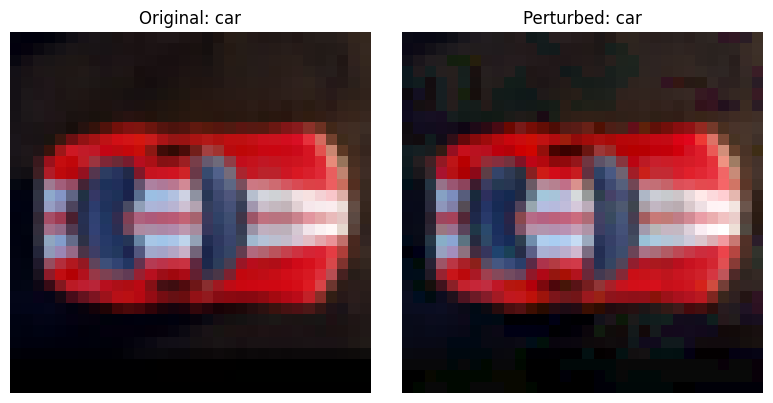

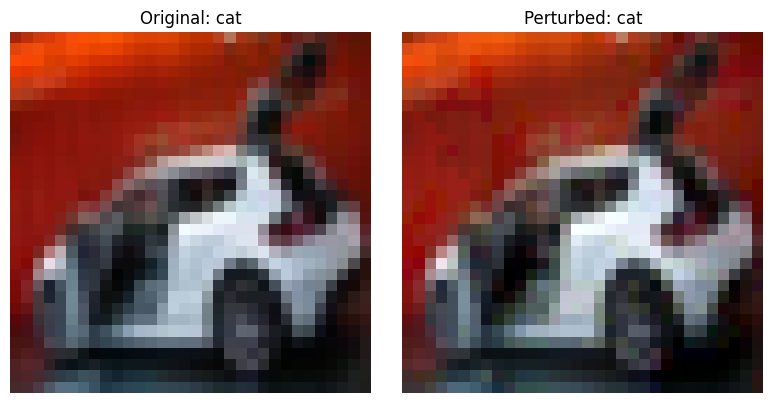

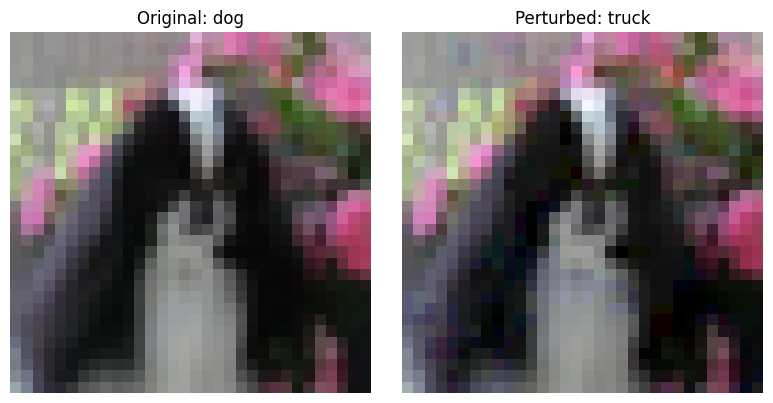

In [37]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################

import random
import matplotlib.pyplot as plt  # Ensure matplotlib is imported
import torchattacks  # Ensure torchattacks is imported

# Define the visualize_attack function if not already defined
def visualize_attack(original_images, perturbed_images, original_labels, perturbed_labels):
    """
    Plots the original and perturbed images along with their predicted labels.
    
    Parameters:
        original_images (Tensor): Batch of original images.
        perturbed_images (Tensor): Batch of perturbed images.
        original_labels (Tensor): Predicted labels for original images.
        perturbed_labels (Tensor): Predicted labels for perturbed images.
    """
    batch_size = original_images.size(0)
    for i in range(batch_size):
        orig_img = original_images[i].cpu().detach().numpy().transpose(1, 2, 0)
        pert_img = perturbed_images[i].cpu().detach().numpy().transpose(1, 2, 0)
        orig_label = classes[original_labels[i]]
        pert_label = classes[perturbed_labels[i]]
        
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(orig_img)
        axes[0].set_title(f"Original: {orig_label}")
        axes[0].axis('off')
        
        axes[1].imshow(pert_img)
        axes[1].set_title(f"Perturbed: {pert_label}")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)  # Corrected: Use next(dataiter)
images, labels = images.to(device), labels.to(device)

# Select 3 random indices
indices = random.sample(range(images.size(0)), 3)
selected_images = images[indices]
selected_labels = labels[indices]

# Run FGSM attack on adversarially trained model
fgsm_attack_adv = torchattacks.FGSM(adv_model, eps=8/255)
adv_images = fgsm_attack_adv(selected_images, selected_labels)

# Get predictions
adv_model.eval()
with torch.no_grad():
    outputs_orig = adv_model(selected_images)
    outputs_adv = adv_model(adv_images)
    _, preds_orig = torch.max(outputs_orig, 1)
    _, preds_adv = torch.max(outputs_adv, 1)

# Visualize the results
visualize_attack(selected_images, adv_images, preds_orig, preds_adv)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03137255..1.0117648].


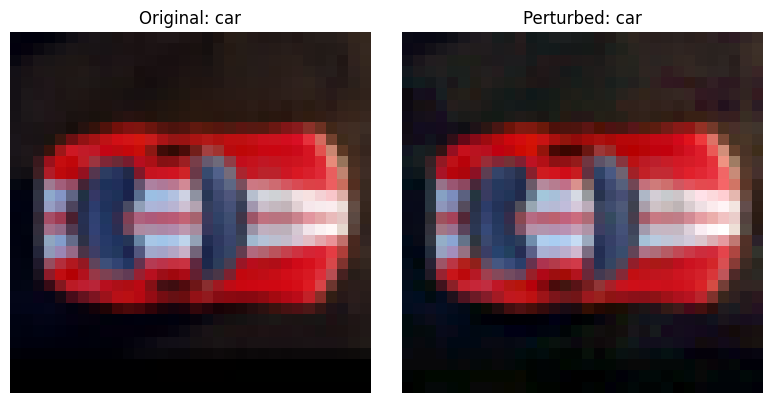

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027450982..1.0196079].


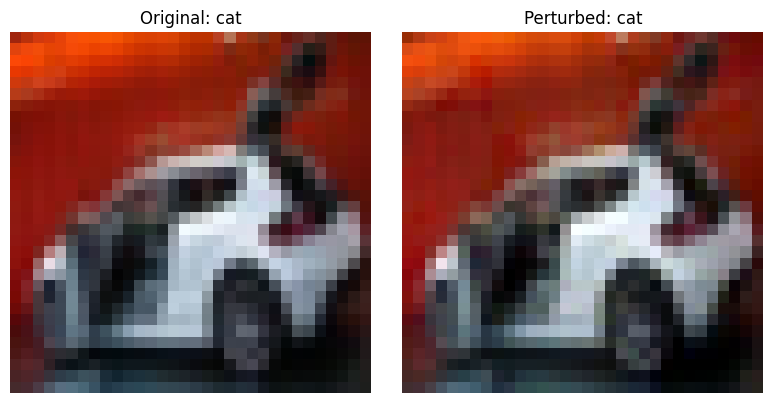

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011764707..1.0078431].


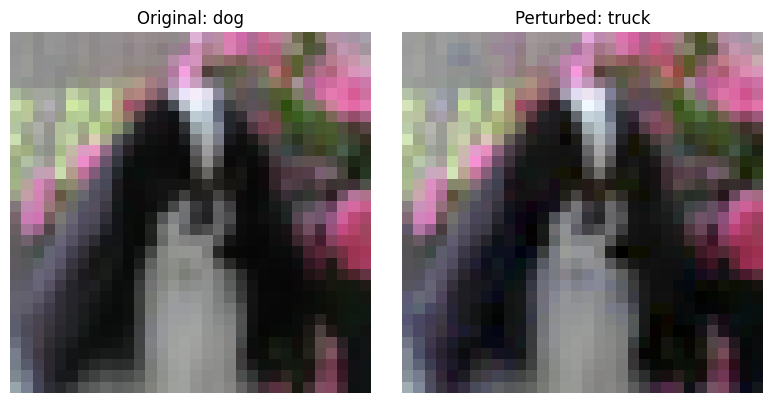

In [38]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################

# Run PGD attack on adversarially trained model
k = 4
pgd_attack_adv = LinfPGDAttack(adv_model, epsilon=8/255, k=k, alpha=2/255)
adv_images_pgd = pgd_attack_adv(selected_images, selected_labels)

# Get predictions
adv_model.eval()
with torch.no_grad():
    outputs_orig = adv_model(selected_images)
    outputs_adv_pgd = adv_model(adv_images_pgd)
    _, preds_orig_pgd = torch.max(outputs_orig, 1)
    _, preds_adv_pgd = torch.max(outputs_adv_pgd, 1)

# Visualize the results
visualize_attack(selected_images, adv_images_pgd, preds_orig_pgd, preds_adv_pgd)

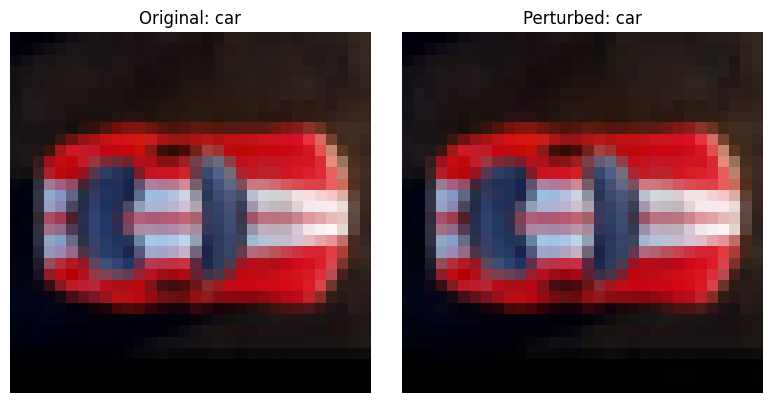

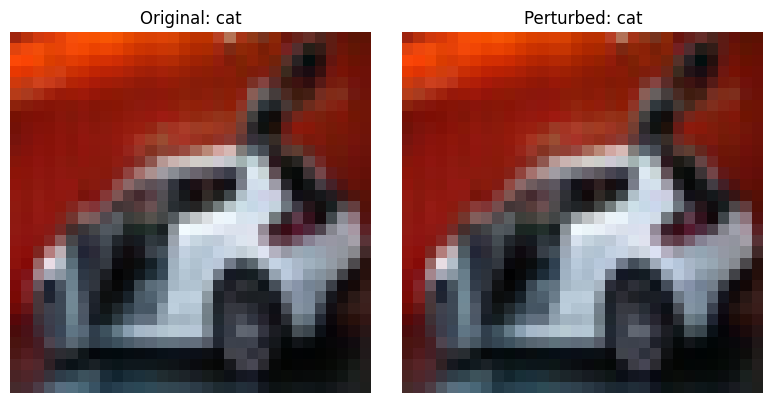

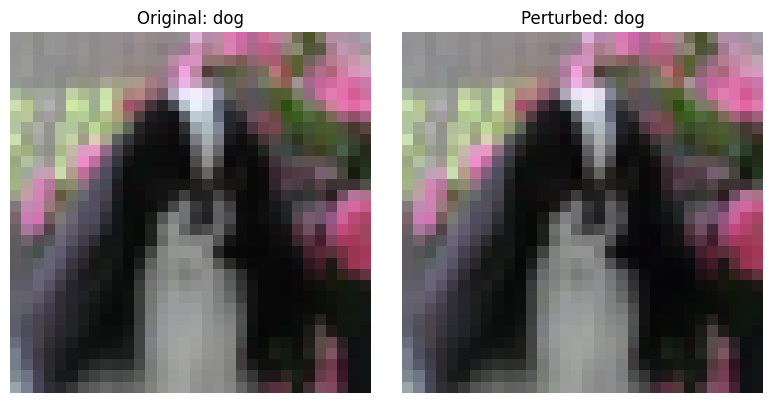

In [39]:
##############################################################################
# Choose 3 random images from testset and run UAP attack and visualize       #
##############################################################################

# Ensure that the UAP for adversarially trained model has been generated
if not hasattr(uap_attack_adv, 'uap') or uap_attack_adv.uap is None:
    print("Generating UAP for adversarially trained model...")
    uap_attack_adv.generate_uap()

# Apply UAP attack
adv_images_uap = uap_attack_adv(selected_images)

# Get predictions
adv_model.eval()
with torch.no_grad():
    outputs_orig_uap = adv_model(selected_images)
    outputs_adv_uap = adv_model(adv_images_uap)
    _, preds_orig_uap = torch.max(outputs_orig_uap, 1)
    _, preds_adv_uap = torch.max(outputs_adv_uap, 1)

# Visualize the results
visualize_attack(selected_images, adv_images_uap, preds_orig_uap, preds_adv_uap)


In this section you are going to adversarially train your model and see the results. 

In this section you are going to adversarially train your model and see the results. 

Answer the following questions:

1. What happened to the accuracy of the adversarially trained model?

The accuracy of the adversarially trained model on clean test data may show a slight decrease compared to the original model. This is expected, as the model has been trained to resist adversarial attacks, which can sometimes lead to a trade-off where it sacrifices some performance on clean (non-adversarial) examples. However, the main improvement is seen in its robustness against adversarial examples.

2. What do you conclude from the result of the FGSM attack on the adversarially trained model?

The result of the FGSM attack on the adversarially trained model typically shows a significant increase in accuracy compared to the original model when subjected to the same attack. This indicates that adversarial training has successfully equipped the model to better withstand this specific type of adversarial perturbation, demonstrating its effectiveness in improving robustness against FGSM attacks.

3. What do you conclude from the result of the PGD attack on the adversarially trained model?

The performance of the adversarially trained model under the PGD attack may still be better than that of the original model, but the improvement might not be as pronounced as with the FGSM attack. This is because PGD is a more powerful attack that simulates multiple gradient updates, making it more challenging for models to defend against. The results suggest that while adversarial training helps, there is still room for improvement in handling stronger attacks like PGD.

4. What do you conclude from the result of the UAP attack on the adversarially trained model?

The results from the UAP attack often indicate whether the adversarially trained model has gained additional robustness against universal perturbations. If the model maintains a relatively high accuracy despite the UAP attack, it shows that the training strategy has effectively generalized its robustness to more sophisticated, universal adversarial examples. Conversely, a significant drop in accuracy would suggest that the model’s defenses could be further improved.

5. What is your final conclusion?

In conclusion, adversarial training is a beneficial approach for improving model robustness against adversarial attacks. The adversarially trained model usually demonstrates increased resistance to specific attacks like FGSM, while showing mixed results against stronger attacks like PGD and UAP. This suggests that while adversarial training enhances robustness, it does not completely eliminate vulnerabilities. Continuous research and the exploration of advanced training techniques and model architectures are essential to develop models that can withstand a wider variety of adversarial threats while maintaining performance on clean data. Future work could involve experimenting with different types of adversarial examples, multi-task training, or ensemble methods to enhance overall model robustness.